# Test CNN models

Give average accuracies for each task, and generate confusion matrix plots.

In [1]:
import sys
sys.path.append("..")

import json
import numpy as np
import keras
from sklearn.metrics import confusion_matrix

2023-08-23 05:05:14.945884: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-23 05:05:16.785616: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from test_model import plot_cm, model_dir, output_dir
from cnn_data import load_data

Importing lots of stuff...


In [6]:
def evaluate_cnn(task_name):
    print(f"Loading data for task {task_name}...")
    _, _, X_test, Y_test = load_data(task_name)
    print(f"Loading model...")
    cnn = keras.models.load_model(f"{model_dir}/cnn/{task_name}_cnn")
    
    Y_pred = np.argmax(cnn.predict(X_test, batch_size=100), axis=1)
    
    cm = confusion_matrix(Y_test, Y_pred).astype(float)
    cm /= np.sum(cm, axis=1, keepdims=True)
    task2label = {
        "scalar1": r"$s\rightarrow\pi^0\pi^0$",
        "axion1": r"$a\rightarrow\gamma\gamma$",
        "axion2": r"$a\rightarrow3\pi^0$"
    }
    labels = [r"$\pi^0$", r"$\gamma$", task2label[task_name]]
    perm = [[2, 1, 0]] * 3
    
    plot_cm(
        cm,
        labels=labels,
        save_path=f"{output_dir}/cnn/{task_name}_cm.pdf"
    )
    test_accuracy = np.mean(Y_pred == Y_test)
    print(f"\nMean test accuracy for {task_name}: {test_accuracy:.5f}")
    
    return test_accuracy, cm

Loading data for task scalar1...
load_data from datafile /usatlas/atlas01/atlasdisk/users/atlas_wifeng/photon-jet/data/h5/pi0_40-250GeV_100k.h5
load_data from datafile /usatlas/atlas01/atlasdisk/users/atlas_wifeng/photon-jet/data/h5/gamma_40-250GeV_100k.h5
load_data from datafile /usatlas/atlas01/atlasdisk/users/atlas_wifeng/photon-jet/data/h5/scalar1_40-250GeV_100k.h5
Loading model...
900/900 [==============================] - 2s 2ms/step

Mean test accuracy for scalar1: 0.94127


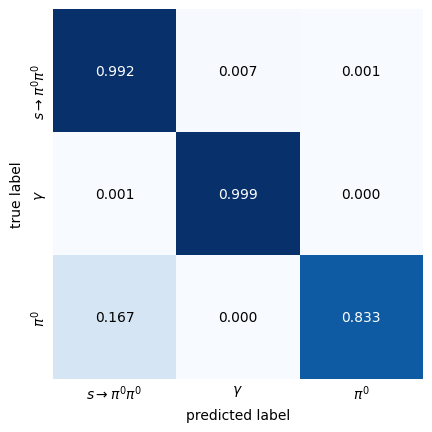

In [7]:
evaluate_cnn("scalar1");

Loading data for task axion1...
load_data from datafile /usatlas/atlas01/atlasdisk/users/atlas_wifeng/photon-jet/data/h5/pi0_40-250GeV_100k.h5
load_data from datafile /usatlas/atlas01/atlasdisk/users/atlas_wifeng/photon-jet/data/h5/gamma_40-250GeV_100k.h5
load_data from datafile /usatlas/atlas01/atlasdisk/users/atlas_wifeng/photon-jet/data/h5/axion1_40-250GeV_100k.h5
Loading model...
900/900 [==============================] - 2s 2ms/step

Mean test accuracy for axion1: 0.80564


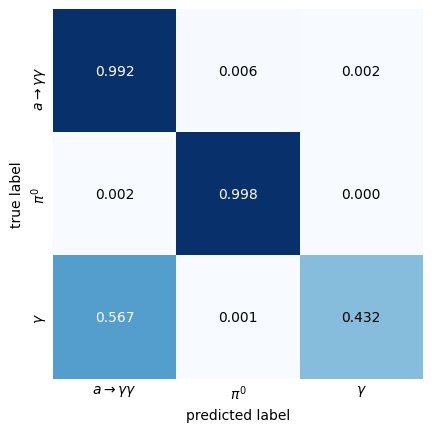

In [5]:
evaluate_cnn("axion1");